In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV


In [5]:
def get_r2_results(path, split = 10, lag = 5):
    behaviour = np.load(path)
    y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
    y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

    ds = np.arange(2,11)
    ls_r2_ksca = []
    ls_su_ksca = []
    ls_r2_sca = []
    ls_su_sca = []
    ls_r2_pca = []
    ls_su_pca = []
    ls_principal_angle_kSCA_SCA = []
    ls_principal_angle_kSCA_PCA = []
    ls_principal_angle_SCA_PCA = []
    for d in ds:
        Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_gaussian.npy")
        X_train = Y_kSCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_kSCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test) )
        ls_su_ksca.append( compute_S_all_pairs(jnp.array(Y_kSCA)))

        Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_linear.npy")
        X_train = Y_SCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_SCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test) )
        ls_su_sca.append( compute_S_all_pairs(jnp.array(Y_SCA)))

        Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_{d}d.npy")
        X_train = Y_PCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_PCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test) )
        ls_su_pca.append( compute_S_all_pairs(jnp.array(Y_PCA)))


        Q_Y_kSCA, _ = qr(Y_kSCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_SCA, _ = qr(Y_SCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_PCA, _ = qr(Y_PCA.swapaxes(1,2).reshape(-1,d))
        ls_principal_angle_kSCA_SCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_SCA))[-1] )
        ls_principal_angle_kSCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_PCA))[-1] )
        ls_principal_angle_SCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_SCA, Q_Y_PCA))[-1] )


    X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
    X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    r2_X = get_reg(X_train,y_train,X_test, y_test)
    return ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA

def get_r2_plots(title, ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca):
    ds = np.arange(2,11)
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(ls_r2_ksca, label='kSCA')
    axs[0].plot(ls_r2_sca, label='kSCA')
    axs[0].plot(ls_r2_pca, label='PCA')
    axs[0].set_title(title)

    axs[0].axhline(r2_X, color='black', linestyle='--')
    axs[0].set_ylabel(r"$R^2$")

    axs[1].plot(ls_su_ksca, label='kSCA')
    axs[1].plot(ls_su_sca, label='SCA')
    axs[1].plot(ls_su_pca, label='PCA')
    axs[1].set_ylabel(r"$S[\phi(U)]$")

    data_length = len(ds) 
    tick_positions = np.linspace(0, data_length - 1, num=9) 
    tick_labels = ds
    for ax in axs:
        ax.set_xlabel(r"$d$")
        ax.set_xticks(tick_positions, tick_labels)
        ax.grid()
        ax.spines[['right', 'top']].set_visible(False)

    plt.legend()
    #plt.suptitle(title)



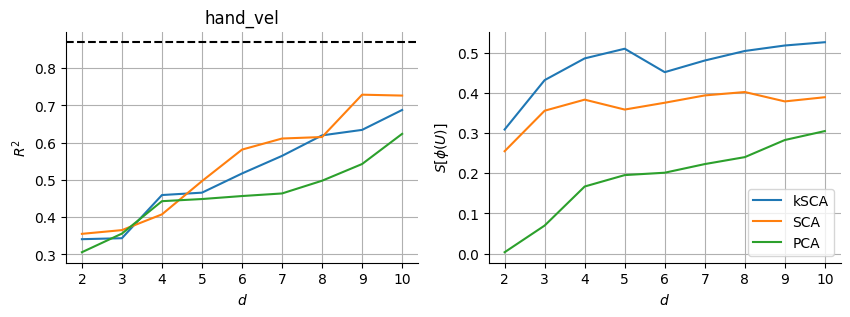

In [6]:
ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA = get_r2_results('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy')
get_r2_plots('hand_vel', ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca)

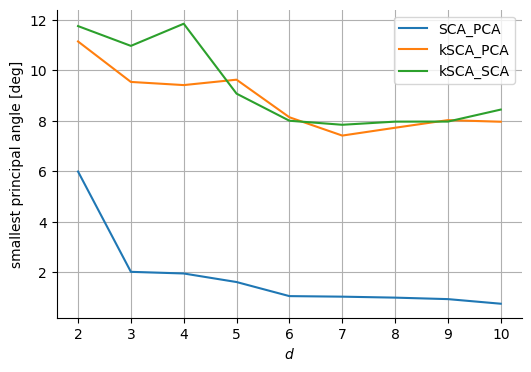

In [7]:
ds = np.arange(2, 11)
data_length = len(ds)
tick_positions = np.linspace(0, data_length - 1, num=9)
tick_labels = ds

fig, ax = plt.subplots(figsize=(6,4))  
ax.plot(ls_principal_angle_SCA_PCA, label='SCA_PCA') 
ax.plot(ls_principal_angle_kSCA_PCA, label='kSCA_PCA')
ax.plot(ls_principal_angle_kSCA_SCA, label='kSCA_SCA')

ax.legend() 
ax.set_xticks(tick_positions)  
ax.set_xticklabels(tick_labels) 
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('smallest principal angle [deg]')
ax.set_xlabel(r"$d$")
ax.grid()

ENDS HERE

In [6]:
split = 10 
lag = 5


behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy')
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

X = np.load('/Users/ariellerosinski/Desktop/Y.npy')
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

print(get_reg(X_train,y_train,X_test, y_test))

X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_3d_gaussian.npy")
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

print(get_reg(X_train,y_train,X_test, y_test))

X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_3d_linear.npy")
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

print(get_reg(X_train,y_train,X_test, y_test))


0.33959593992504417
0.34349564963510254
0.36523764555681093
